In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
import torch
from torch import nn
from tqdm import tqdm

In [3]:
animation.writer = animation.writers['ffmpeg']

## Generate data and animation from scratch

In [71]:
# Parameters
g = 9.81  # acceleration due to gravity (m/s^2)
l1 = 1.0  # length of the first rod (m)
l2 = 1.0  # length of the second rod (m)
m1 = 1.0  # mass of the first bob (kg)
m2 = 1.0  # mass of the second bob (kg)
t_final = 20.0  # simulation time (s)
exp_name = 'presentation_chaos'
num_tsteps = 2000

# Initial conditions
twiddle = 1e-6
theta1_init = np.pi - 1e-1  # initial angle of the first pendulum (rad)
theta2_init = np.pi + 1e-1 # initial angle of the second pendulum (rad)
theta1_init2 = np.pi - 1e-1 + twiddle  # initial angle of the first pendulum in the second set of pendulums (rad)
theta2_init2 = np.pi + 1e-1 + twiddle  # initial angle of the second pendulum in the second set of pendulums (rad)
theta1_init3 = np.pi - 1e-1 - twiddle  # initial angle of the first pendulum in the third set of pendulums (rad)
theta2_init3 = np.pi + 1e-1 - twiddle  # initial angle of the second pendulum in the third set of pendulums (rad)
z1_init = 0.0            # initial angular velocity of the first pendulum (rad/s)
z2_init = 0.0            # initial angular velocity of the second pendulum (rad/s)

# Equations of motion
def derivatives(t, state):
    theta1, z1, theta2, z2 = state
    delta = theta2 - theta1

    denominator1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta) ** 2
    denominator2 = (l2 / l1) * denominator1

    dtheta1_dt = z1
    dz1_dt = (
        (m2 * l1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * l2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denominator1
    )
    dtheta2_dt = z2
    dz2_dt = (
        (-m2 * l2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * l1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denominator2
    )

    return np.array([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])


state_0 = np.array([theta1_init, z1_init, theta2_init, z2_init])
state_02 = np.array([theta1_init2, z1_init, theta2_init2, z2_init])
state_03 = np.array([theta1_init3, z1_init, theta2_init3, z2_init])
t = np.linspace(0, t_final, num_tsteps)  # time array

# Solve the system
solution = solve_ivp(derivatives, (0, t_final), state_0, t_eval=t)
solution2 = solve_ivp(derivatives, (0, t_final), state_02, t_eval=t)
solution3 = solve_ivp(derivatives, (0, t_final), state_03, t_eval=t)
theta1, theta2 = solution.y[0], solution.y[2]
theta1_2, theta2_2 = solution2.y[0], solution2.y[2]
theta1_3, theta2_3 = solution3.y[0], solution3.y[2]

# Convert to Cartesian coordinates
x1 = l1 * np.sin(theta1)
y1 = -l1 * np.cos(theta1)
x2 = x1 + l2 * np.sin(theta2)
y2 = y1 - l2 * np.cos(theta2)
x1_2 = l1 * np.sin(theta1_2)
y1_2 = -l1 * np.cos(theta1_2)
x2_2 = x1_2 + l2 * np.sin(theta2_2)
y2_2 = y1_2 - l2 * np.cos(theta2_2)
x1_3 = l1 * np.sin(theta1_3)
y1_3 = -l1 * np.cos(theta1_3)
x2_3 = x1_3 + l2 * np.sin(theta2_3)
y2_3 = y1_3 - l2 * np.cos(theta2_3)

# Animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-(l1+l2)*1.1, (l1+l2)*1.1)
ax.set_ylim(-(l1+l2)*1.1, (l1+l2)*1.1)
ax.set_aspect('equal')
line, = ax.plot([], [], '-', lw=2, color='blue')
line2, = ax.plot([], [], '-', lw=2, color='red')
line3, = ax.plot([], [], '-', lw=2, color='black')
m1_pt, = ax.plot([], [], 'o', color='blue', markersize=m1*10)
m2_pt, = ax.plot([], [], 'o', color='blue', markersize=m2*10)
m1_2_pt, = ax.plot([], [], 'o', color='red', markersize=m1*10)
m2_2_pt, = ax.plot([], [], 'o', color='red', markersize=m2*10)
m1_3_pt, = ax.plot([], [], 'o', color='black', markersize=m1*10)
m2_3_pt, = ax.plot([], [], 'o', color='black', markersize=m2*10)

def update(frame):
    line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
    m1_pt.set_data([x1[frame]], [y1[frame]])
    m2_pt.set_data([x2[frame]], [y2[frame]])
    line2.set_data([0, x1_2[frame], x2_2[frame]], [0, y1_2[frame], y2_2[frame]])
    m1_2_pt.set_data([x1_2[frame]], [y1_2[frame]])
    m2_2_pt.set_data([x2_2[frame]], [y2_2[frame]])
    line3.set_data([0, x1_3[frame], x2_3[frame]], [0, y1_3[frame], y2_3[frame]])
    m1_3_pt.set_data([x1_3[frame]], [y1_3[frame]])
    m2_3_pt.set_data([x2_3[frame]], [y2_3[frame]])
    return line,

ani = FuncAnimation(fig, update, frames=len(t), interval=(t_final / 2), blit=True)
ani.save(f'../animations/{exp_name}.mp4')
plt.close(fig)

<video src='../animations/presentation_l1p5_m3.mp4' controls>

## Pull data from generated dataset and animate

In [43]:
# Set animation parameters
row_of_dataset = 500
# dataset_name = 'simulations-zero_initial_velocity-equal_mass-equal_length'
dataset_name = 'raw_data'

# Load and parse data
with open(f'../data/{dataset_name}.json', 'r') as f:
    data = json.load(f)
solution = data[row_of_dataset]
theta1, theta2 = solution['theta1'], solution['theta2']
plt.plot(theta1)
plt.plot(theta2)
# num_tsteps, t_final = solution['num_tsteps'], solution['t_final']
# l1, l2, m1, m2 = solution['length1'], solution['length2'], solution['mass1'], solution['mass2']

# # Convert to Cartesian coordinates
# x1 = l1 * np.sin(theta1)
# y1 = -l1 * np.cos(theta1)
# x2 = x1 + l2 * np.sin(theta2)
# y2 = y1 - l2 * np.cos(theta2)

# # Animation
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_xlim(-(l1+l2)*1.1, (l1+l2)*1.1)
# ax.set_ylim(-(l1+l2)*1.1, (l1+l2)*1.1)
# ax.set_aspect('equal')
# line, = ax.plot([], [], 'o-', lw=2, color='blue')

# def update(frame):
#     line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
#     return line,

# ani = FuncAnimation(fig, update, frames=len(t), interval=(t_final / num_tsteps * 1000), blit=True)
# ani.save(f'../animations/{dataset_name}.mp4')
# plt.close(fig)

([0.2564565431501872,
  0.2564039157800971,
  0.25624604674605067,
  0.2559829751347762,
  0.2556147661638948,
  0.2551415112052587,
  0.2545633360591752,
  0.2538805252220951,
  0.2530932719360138,
  0.2522017377775186,
  0.25120611218265343,
  0.25010661244691906,
  0.2489034837252728,
  0.24759699903212873,
  0.24618745924135763,
  0.2446751930862869,
  0.24306055715970074,
  0.24134393591383996,
  0.2395257416604021,
  0.2376064145705414,
  0.23558642267486876,
  0.23346626186345182,
  0.23124645588581486,
  0.22892755635093887,
  0.22651014272726158,
  0.22399482234267737,
  0.2213822303845373,
  0.21867302989964918,
  0.21586791179427747,
  0.2129675948341433,
  0.2099728256444246,
  0.20688437870975585,
  0.20370305637422834,
  0.20042968884138992,
  0.19706513417424537,
  0.19361027829525593,
  0.19006603498633956,
  0.18643334588887112,
  0.1827131805036819,
  0.17890653619106003,
  0.17501443817075035,
  0.17103791434146937,
  0.16697789515530595,
  0.16283541614547128,
  0.1

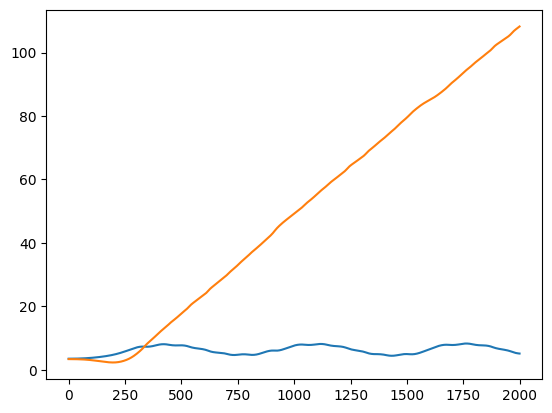

In [50]:
lim = 100
for solution in data:
    theta1, theta2 = solution['theta1'], solution['theta2']
    if np.max(theta1) > lim or np.max(theta2) > lim:
        plt.plot(theta1)
        plt.plot(theta2)
        break

<video src='../animations/test_access.mp4' controls>

## Generate data from pretrained model and animate

In [47]:
class FeedForward(nn.Module):
    #So bog basic it should tap for black mana
    #DT That one's for you
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 30)
        self.linear2 = nn.Linear(30,30)
        self.linear3 = nn.Linear(30,30)
        self.linear4 = nn.Linear(30,4)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = torch.clamp(x, -1e6, 1e6)
        return x

In [48]:
test_arry = (np.random.rand(10)*20)-10
print(test_arry)
modded_arry = ((test_arry+np.pi)%(2*np.pi))-np.pi
print(modded_arry)
assert np.all(modded_arry >= -np.pi)
assert np.all(modded_arry <= np.pi)

[ 2.91603984 -6.27201204  2.61648346 -0.43060226  0.11249292 -2.50269192
  4.28607758 -8.79656889 -8.43970489  0.81513774]
[ 2.91603984  0.01117327  2.61648346 -0.43060226  0.11249292 -2.50269192
 -1.99710773 -2.51338358 -2.15651959  0.81513774]


In [49]:
# Set parameters
model_name = 'shuffled_4dout_online_450000_epochs_statedict'
l1, l2 = 1, 1
m1, m2 = 1, 1

for i in range(5):
    theta1_init, theta2_init = float((np.random.randn() - 1)*3), float((np.random.randn() - 1)*3)
    z1_init, z2_init = 2, -5
    timestep = 1/200 # don't change unless the dataset changes
    total_time = 10

    # Calculate other parameters
    num_tsteps = int(total_time / timestep)

    # Load model
    model = FeedForward()
    model.load_state_dict(torch.load(f'../models/{model_name}.torch', weights_only=True))
    model.eval()

    # Generate data using model
    unchanged_state = torch.tensor([l1, l2, m1, m2])
    init_state = torch.tensor([theta1_init, z1_init, theta2_init, z2_init])
    solution = [init_state]
    with torch.no_grad():
        for _ in range(int(total_time/timestep)):
            next_state = model(solution[-1])
            next_state = ((next_state+torch.pi)%(2*torch.pi))-torch.pi
            assert torch.min(next_state) >=-torch.pi
            assert torch.max(next_state) <= torch.pi
            solution.append(next_state)

    theta1 = [sol[0] for sol in solution]
    theta2 = [sol[2] for sol in solution]

    # Convert to Cartesian coordinates
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    # Animation
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-(l1+l2)*1.1, (l1+l2)*1.1)
    ax.set_ylim(-(l1+l2)*1.1, (l1+l2)*1.1)
    ax.set_aspect('equal')
    line, = ax.plot([], [], 'o-', lw=2, color='blue')

    def update(frame):
        line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        return line,

    ani = FuncAnimation(fig, update, frames=num_tsteps+1, interval=(total_time / num_tsteps * 1000), blit=True)
    ani.save(f'../animations/{model_name}_{i}.mp4')
    plt.close(fig)

<video src='../animations/shuffled_4dout_online_450000_epochs_statedict_1.mp4' controls>

<video src='../animations/shuffled_4dout_online_450000_epochs_statedict_4.mp4' controls>

<video src='../animations/shuffled_4dout_online_410000_epochs_statedict.mp4' controls>

## Loop through checkpoints, generate simulations, analyze both loss components

In [29]:
g = 9.81
def derivatives(t, state):
    m1, m2, L1, L2 = 1,1,1,1
    if torch.nan in state:
        raise ValueError()
    if torch.inf in state or -torch.inf in state:
        raise ValueError()
    # theta1, theta2, z1, z2 = torch.split(state, 1, dim=1)
    theta1, theta2, z1, z2 = torch.squeeze(state)
    delta = theta2 - theta1
    if torch.nan in delta:
        raise ValueError()
    if torch.inf in delta or -torch.inf in delta:
        raise ValueError()

    denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    denominator2 = (L2 / L1) * denominator1

    dtheta1_dt = z1
    dz1_dt = (
        (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * L2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denominator1
    )
    if torch.nan in dz1_dt:
        raise ValueError()
    dtheta2_dt = z2
    dz2_dt = (
        (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denominator2
    )
    return np.column_stack([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])

def rk4_derivs(state, f, h):
    t = 0
    k1 = f(t, state)
    k2 = f(t + h*0.5, state + k1*h*0.5)
    k3 = f(t + h*0.5, state + k2*h*0.5)
    k4 = f(t + h, state + k3*h)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

class PINNLosses(nn.Module):
    def __init__(self, tstep, lamb=.5):
        super().__init__()
        self.tstep = tstep
        self.lamb = lamb
        self.data_crit = nn.MSELoss()
        self.physics_crit = nn.MSELoss()

    def forward(self, y_pred, y_true, input_data):
        data_loss = self.data_crit(y_pred, y_true)
        
        empirical_derivs = (y_pred - input_data) / self.tstep
        true_derivs = torch.tensor(rk4_derivs(input_data, derivatives, self.tstep))
        physics_loss = self.physics_crit(empirical_derivs, true_derivs)

        return self.lamb * data_loss, (1-self.lamb) * physics_loss

In [31]:
l1, l2 = 1, 1
m1, m2 = 1, 1
theta1_init, theta2_init = float(np.random.uniform(-np.pi, np.pi)), float(np.random.uniform(-np.pi, np.pi))
z1_init, z2_init = 0, 0
total_time = 10
lamb = 0.5
timestep = 1/200 # don't change unless the dataset changes
loss = PINNLosses(tstep=timestep, lamb=lamb)

data_losses = []
physics_losses = []
for epoch_num in tqdm(range(10000, 460000, 10000)):
    model_name = f'shuffled_4dout_online_{epoch_num}_epochs_statedict'

    # Calculate other parameters
    num_tsteps = int(total_time / timestep)

    # Load model
    model = FeedForward()
    model.load_state_dict(torch.load(f'../models/{model_name}.torch', weights_only=True))
    model.eval()

    # Generate data using model
    unchanged_state = torch.tensor([l1, l2, m1, m2])
    init_state = torch.tensor([theta1_init, z1_init, theta2_init, z2_init])
    solution = [init_state]
    data_losses_local = []
    physics_losses_local = []
    with torch.no_grad():
        for _ in range(int(total_time/timestep)):
            next_state = model(solution[-1])
            next_state_true = solution[-1]+rk4_derivs(solution[-1], derivatives, timestep)*timestep
            data_loss, physics_loss = loss(next_state, next_state_true, solution[-1])
            data_losses_local.append(data_loss.item())
            physics_losses_local.append(physics_loss.item())
            next_state = ((next_state+torch.pi)%(2*torch.pi))-torch.pi
            assert torch.min(next_state) >=-torch.pi
            assert torch.max(next_state) <= torch.pi
            solution.append(torch.squeeze(next_state))

    data_losses.append(np.mean(data_losses_local))
    physics_losses.append(np.mean(physics_losses_local))

100%|██████████| 45/45 [02:45<00:00,  3.67s/it]


In [39]:
np.max(physics_losses)

22.215182688951494

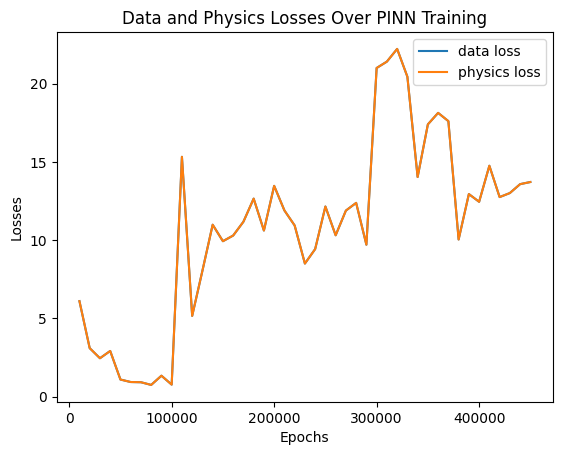

In [46]:
checkpoint_epoch_nums = list(range(10000, 460000, 10000))
plt.plot(checkpoint_epoch_nums, np.array(data_losses) * 4e4, label='data loss')
plt.plot(checkpoint_epoch_nums, physics_losses, label='physics loss')
plt.title('Data and Physics Losses Over PINN Training')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()